In [133]:
import os 
import numpy as np
import sympy
import cirq
import tensorflow_quantum as tfq
from tqdm import tqdm
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

from utilities.variational import VQE
from utilities.circuit_basics import Evaluator
from utilities.idinserter import IdInserter
from utilities.simplifier import Simplifier
from utilities.unitary_killer import UnitaryMurder

%load_ext autoreload
%autoreload 2


n_qubits = 4
qlr = 0.01
qepochs = 10**3
verbose=0
g=1
J=0
noise=0.0
problem="TFIM"


vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=qepochs, patience=100,
              random_perturbations=True, verbose=verbose, g=g, J = J, 
              problem=problem, noise_model=None)
indexed_circuit = [vqe_handler.n_qubits+k+vqe_handler.number_of_cnots for k in range(vqe_handler.n_qubits)]
circuit, symbols, idx = vqe_handler.give_circuit(indexed_circuit)
clean_energy = vqe_handler.vqe(indexed_circuit)
print("clean_energy: ",clean_energy[0])
circuit

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
clean_energy:  -3.9999993


(0, 0): ───Rx(th_0)───

(0, 1): ───Rx(th_1)───

(0, 2): ───Rx(th_2)───

(0, 3): ───Rx(th_3)───

In this kind of testing notebook, we consider a product ansatz as above and optimize the parameters for different values of $p$ in depolarizing channel. To implement this we consider a batch of circuits - in this case 10^3 - and apply before each of the parametrized gates - R_x(\theta) in this case - one of the four unitary transf of the depolarizing channel, with the corresponding probability. Then the energy is averaged over the batch, and the parameters optimzied considering this expected value. We then study the evolution of the (lowest found) configuration as a function of the noise strength p.

In [53]:
ps=[]
for k in range(1,8)[::-1]:
    ps = np.append(ps, np.linspace(10**(-k), 10**(-k+1),10))
    noisy_energy=[]

els={}
for ind,p in tqdm(enumerate(ps)):
    vqe_handler = VQE(n_qubits=n_qubits, lr=qlr, epochs=10**3, patience=100,
                          random_perturbations=True, verbose=0, g=g, J = J, 
                          problem=problem, noise_model={ "channel":"depolarizing", "channel_params":[p], "q_batch_size":10**3})
    noisy_energy, noisy_symbols, nh = vqe_handler.vqe(indexed_circuit)
    els[str(ind)] = [noisy_energy, noisy_symbols, nh.history["loss"]]
    
with open("els1000.pkl","wb") as p:
    pickle.dump(els,p,pickle.HIGHEST_PROTOCOL)
    
#with open("ens.pkl","rb") as f:
    #g = pickle.load(f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


70it [2:07:00, 108.87s/it]


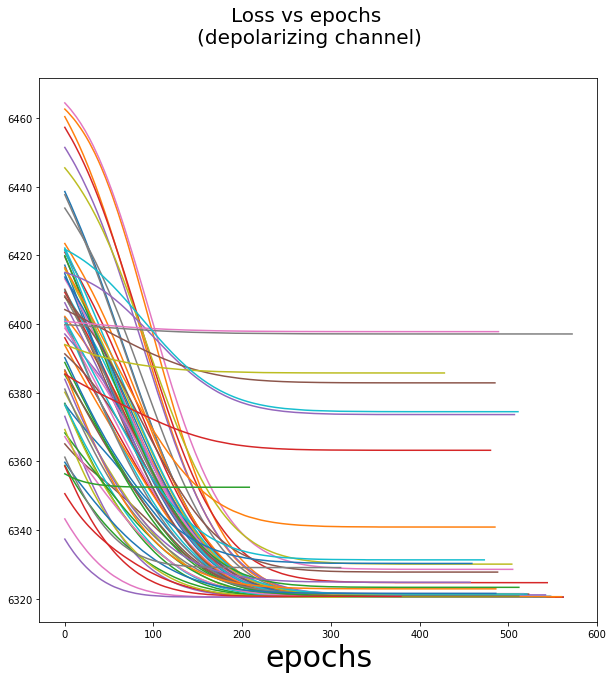

In [130]:
plt.figure(figsize=(10,10))
plt.suptitle("Loss vs epochs \n(depolarizing channel)", size=20)
noisy_energy=[]
for key,val in els.items():
    noisy_energy.append(val[0])
    plt.plot(val[-1], label="p = {}".format(ps[int(key)]))
    #noisy_energy.append(val[0])
plt.xlabel("epochs", size=30)
plt.savefig("training.png")

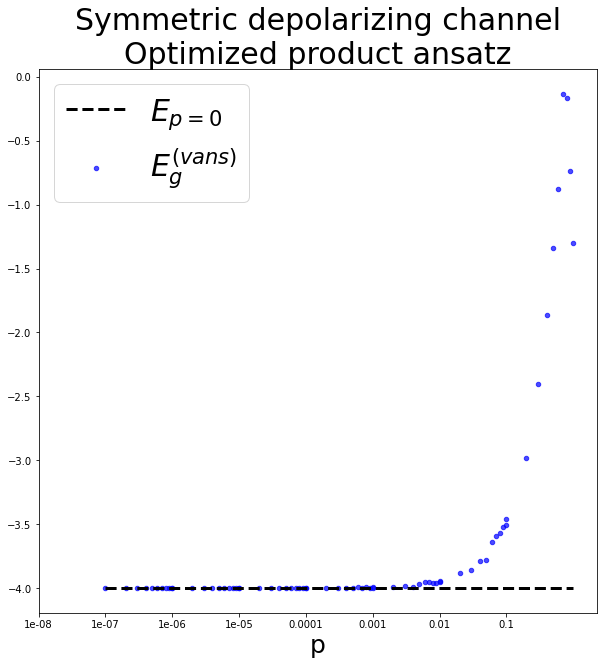

In [131]:
plt.figure(figsize=(10,10))
ax1 = plt.subplot2grid((1,1),(0,0))
ax1.set_title("Symmetric depolarizing channel\nOptimized product ansatz", size=30)
ax1.plot(np.log10(ps),[clean_energy[0]]*len(noisy_energy), '--', linewidth=3, color="black", label=r'$E_{p=0}$')
ax1.scatter(np.log10(ps),noisy_energy, color="blue", s=20, alpha=0.7, label=r'$E^{(vans)}_{g}$')
ax1.set_xticks(np.log10([10**-k for k in range(1,9)]))
ax1.set_xticklabels([10**-k for k in range(1,9)])
ax1.set_xlabel("p",size=25)
ax1.legend(prop={"size":30})
#ax1.set_xticklabels([str(k) for k in np.linspace(np.min(ps), np.max(ps),10)])
plt.savefig("ges_energy.png")

In [150]:
params = []
for k in els.keys():
    params.append(list(els[k][1].values()))
params = np.array(params)

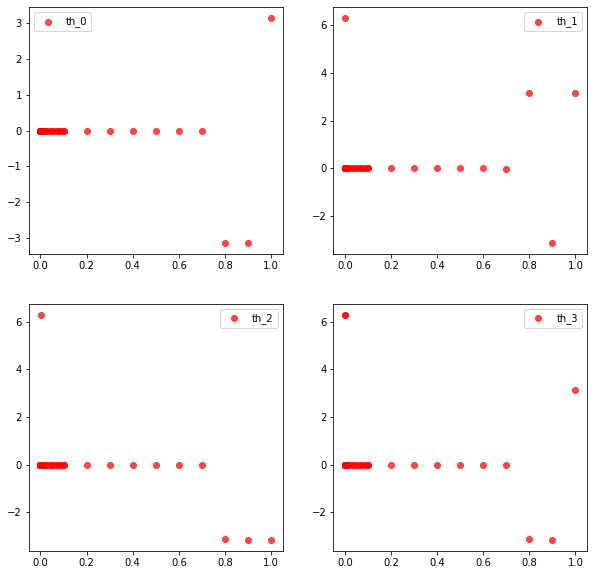

In [155]:
plt.figure(figsize=(10,10))
inds = [(0,0),(0,1),(1,0),(1,1)]
for a in range(4):
    ax = plt.subplot2grid((2,2),inds[a])
    ax.scatter(ps,params[:,a], label="th_{}".format(a), alpha=0.7, color="red")
    ax.legend()